<a href="https://colab.research.google.com/github/kapilrahtor/Speech_Processing/blob/main/Assignment4_MTech_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle/'
!kaggle competitions download -c tensorflow-speech-recognition-challenge
!unzip *.zip
!7za x 'train.7z'
!7za x 'test.7z'

100% 3.50G/3.50G [00:31<00:00, 115MB/s] 
100% 3.50G/3.50G [00:31<00:00, 121MB/s]
Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                             

In [6]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd
import plotly as py
import plotly.graph_objs as go

In [8]:
files = []
target_series = []
for dirname, _, filenames in os.walk('/content/train/audio/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        target = filepath.split('/')[-2]
        if target not in '_background_noise_':
            target_series.append(target)
            files.append(filepath)
data = pd.DataFrame(target_series, columns=['target'])
data['filename'] = files
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data.head()

,target,filename
0,dog,/content/train/audio/dog/9735764a_nohash_0.wav
1,six,/content/train/audio/six/c5c60d8d_nohash_0.wav
2,yes,/content/train/audio/yes/d33df435_nohash_0.wav
3,happy,/content/train/audio/happy/435f9f9e_nohash_2.wav
4,six,/content/train/audio/six/bfaf2000_nohash_3.wav


In [10]:
data

,target,filename
0,dog,/content/train/audio/dog/9735764a_nohash_0.wav
1,six,/content/train/audio/six/c5c60d8d_nohash_0.wav
2,yes,/content/train/audio/yes/d33df435_nohash_0.wav
3,happy,/content/train/audio/happy/435f9f9e_nohash_2.wav
4,six,/content/train/audio/six/bfaf2000_nohash_3.wav
...,...,...
62341,go,/content/train/audio/go/4f5c0b28_nohash_1.wav
62342,right,/content/train/audio/right/8a28231e_nohash_0.wav
62343,left,/content/train/audio/left/dbaf8fc6_nohash_1.wav
62344,nine,/content/train/audio/nine/26e573a9_nohash_0.wav


In [11]:
df = pd.DataFrame()
for target in data['target'].unique():
    df = df.append(data[data['target']==target].sample(150))
df = df.sample(frac=1)
df = df.reset_index(drop=True)
df.head()

<ipython-input-11-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-11-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-11-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-11-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data[data['target']==target].sample(150))
<ipython-input-11-a93b282b541a>:3: FutureWarning: The frame.append method is deprecated and 

,target,filename
0,go,/content/train/audio/go/888a0c49_nohash_0.wav
1,wow,/content/train/audio/wow/0135f3f2_nohash_0.wav
2,right,/content/train/audio/right/ffbb695d_nohash_0.wav
3,go,/content/train/audio/go/b9f46737_nohash_0.wav
4,off,/content/train/audio/off/653a48f5_nohash_0.wav


In [12]:
df.shape

(4350, 2)

In [13]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x , sr = librosa.load(path)
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T,axis=0)
    except:
        print('Error reading audio')
    return mfccs

In [14]:
X_df = pd.DataFrame(df['filename'].apply(lambda x: create_mfcc_features(x)).tolist())

In [15]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-385.296844,130.582428,20.648735,37.158508,11.376739,12.550095,12.476611,5.091612,-2.221662,-3.663179,...,-0.312358,1.224027,-0.735876,-0.658408,0.921289,-0.759631,-0.524505,-0.197024,0.193836,0.644013
1,-449.649017,119.504097,-16.533205,2.700958,-15.624456,-25.207806,-11.842435,-9.899075,-18.322508,-16.831820,...,0.689050,0.806266,0.466412,0.740672,1.355888,1.421244,0.593986,-0.083739,-0.314234,-0.333125
2,-429.411041,134.751892,-37.178364,5.087168,-1.178571,-10.997178,-11.265524,-7.457412,-2.290957,-10.038706,...,-0.035142,-0.261946,-0.437105,-0.493867,-0.055180,-0.062049,-0.215107,0.382880,0.133169,0.111948
3,-441.841278,132.554535,24.459785,13.564393,-4.739087,2.137385,-1.652694,2.546808,-4.142304,-4.897997,...,0.136121,0.239820,-0.252552,0.209915,-0.223046,-0.183744,0.308126,-0.082199,-0.407012,-0.002643
4,-363.619598,107.983498,-2.351189,17.980078,-23.421673,4.921921,8.002339,18.271734,2.231195,6.599397,...,0.021099,0.290696,0.965028,0.209507,-0.446257,0.204687,-0.491416,-0.004846,0.876230,0.196349


In [16]:
from sklearn.preprocessing import StandardScaler
object= StandardScaler()
X_sc = object.fit_transform(X_df)
X_sc
print(X_sc.shape)

(4350, 128)


In [20]:
X_sc

array([[ 4.1840455e-01,  7.8049576e-01,  1.8784703e+00, ...,
        -5.4357719e-01,  4.6833444e-01,  1.4656905e+00],
       [-1.9471684e-01,  4.3087071e-01,  2.3594303e-01, ...,
        -2.8537223e-01, -7.3154759e-01, -7.1294308e-01],
       [-1.8976154e-03,  9.1208136e-01, -6.7606527e-01, ...,
         7.7816606e-01,  3.2506043e-01,  2.7939531e-01],
       ...,
       [-9.8414260e-01,  1.8895176e-01, -5.3908670e-01, ...,
         9.0642202e-01, -2.2073982e+00,  1.0687347e-01],
       [-1.4932123e+00, -1.0252059e+00,  1.0683866e+00, ...,
        -7.8569603e-01, -2.7177539e-01, -3.9858317e-01],
       [-1.0545263e-01, -1.4464872e+00,  7.9577738e-01, ...,
        -7.2965592e-01,  1.1876162e+00, -6.2471700e-01]], dtype=float32)

# MODELS

In [26]:
len(df['target'].unique())

29

In [ ]:
X_df.shape

In [21]:
encoder = LabelEncoder()
encoder.fit(df['target'])
y = encoder.transform(df['target'])

In [22]:
y

array([ 8, 26, 17, ..., 28,  8, 24])

In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

In [28]:
x_train, x_val, y_train, y_val = train_test_split(np.array(X_df), y, test_size=0.10, stratify=y)

In [29]:
x_train = x_train.reshape(x_train.shape[0], 16, 8, 1)
x_val = x_val.reshape(x_val.shape[0], 16, 8, 1)

In [30]:
x_train.shape

(3915, 16, 8, 1)

In [31]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 8, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(data['target'].unique()), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 4, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 8)           1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 2, 8)           0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
123/123 [==============================] - 2s 6ms/step - loss: 4.7517 - accuracy: 0.0396
Epoch 2/200
123/123 [==============================] - 1s 9ms/step - loss: 3.3754 - accuracy: 0.0388
Epoch 3/200
123/123 [==============================] - 1s 7ms/step - loss: 3.3656 - accuracy: 0.0444
Epoch 4/200
123/123 [==============================] - 1s 8ms/step - loss: 3.3558 - accuracy: 0.0437
Epoch 5/200
123/123 [==============================] - 1s 7ms/step - loss: 3.3465 - accuracy: 0.0567
Epoch 6/200
123/123 [==============================] - 1s 6ms/step - loss: 3.3271 - accuracy: 0.0577
Epoch 7/200
123/123 [==============================] - 1s 7ms/step - loss: 3.3022 - accuracy: 0.0639
Epoch 8/200
123/123 [==============================] - 1s 8ms/step - loss: 3.2563 - accuracy: 0.0720
Epoch 9/200
123/123 [==============================] - 1s 10ms/step - loss: 3.2065 - accuracy: 0.0925
Epoch 10/200
123/123 [==============================] - 1s 11ms/step - loss: 3.1353 - accu

In [34]:
prob_val = model.predict(x_val)
pred_val = np.argmax(prob_val, axis=1)
pred_val = encoder.inverse_transform(pred_val)

14/14 [==============================] - 0s 7ms/step


<Axes: >

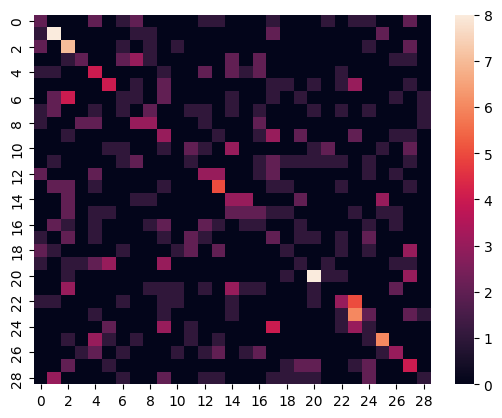

In [35]:
sns.heatmap(confusion_matrix(encoder.inverse_transform(y_val), pred_val))

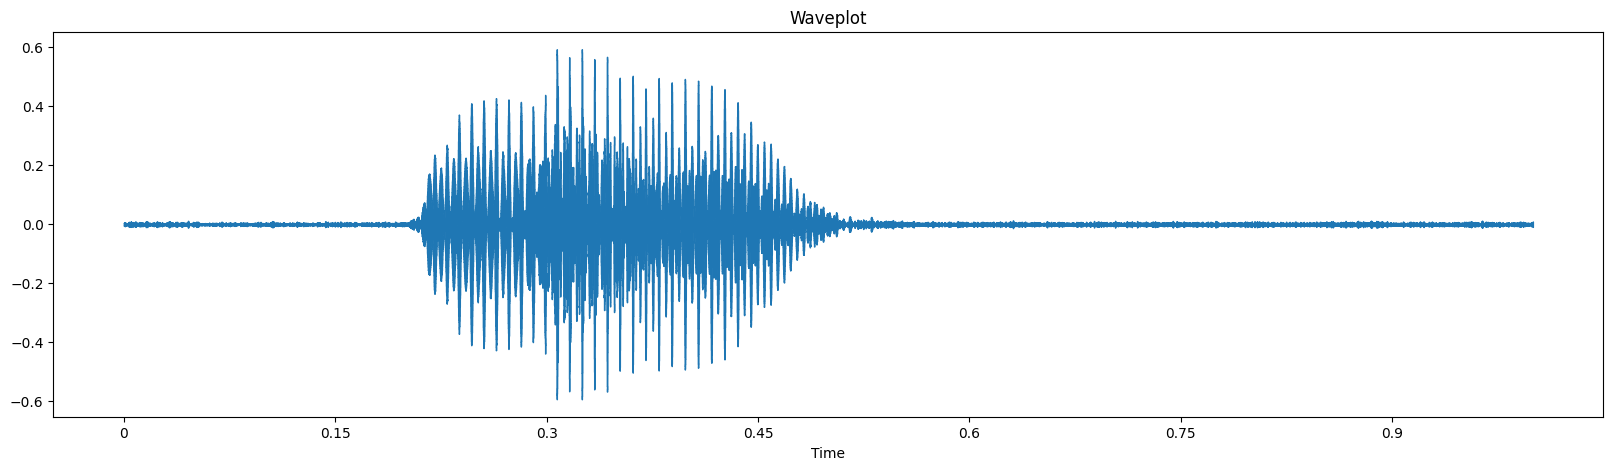

In [36]:
x , sr = librosa.load('/content/My_audio_No.wav')
plt.figure(figsize=(20, 5))
plt.title('Waveplot')
librosa.display.waveshow(x, sr=sr)
plt.show()

In [37]:
x.shape

(22050,)

In [38]:
total_time = x.shape[0]/sr
per_window = x.shape[0]/total_time
total_time, per_window

(1.0, 22050.0)

In [39]:
ipd.Audio('/content/My_audio_No.wav')

In [ ]:
mfccs_test = librosa.feature.mfcc(y=x[int(2.3*per_window):int(2.6*per_window)], sr=sr, n_mfcc=128)
mfccs = np.mean(mfccs.T,axis=0)

In [43]:
mfccs_test = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)



In [44]:
mfccs_test

array([[-4.1838702e+02, -3.8180222e+02, -3.8408008e+02, ...,
        -3.7357068e+02, -3.7564651e+02, -4.0766769e+02],
       [ 8.0102768e+01,  8.3973083e+01,  7.9983948e+01, ...,
         7.3192818e+01,  7.8671524e+01,  7.5266174e+01],
       [ 7.1756840e+00, -5.5089912e+00, -9.5479736e+00, ...,
        -1.9510492e+01, -1.1729448e+01, -6.1436272e-01],
       ...,
       [-1.9891853e+00, -1.9884853e+00, -1.9219780e-01, ...,
        -4.3827391e+00, -1.7711430e+00, -5.9123230e-01],
       [ 1.9941263e+00, -7.3376751e-01, -2.5476651e+00, ...,
        -1.8451138e+00,  1.9103637e+00,  1.8916340e+00],
       [-7.6505280e-01,  2.2910309e-01,  4.0640640e-01, ...,
         7.4970245e-01,  2.8767052e+00,  3.3881721e+00]], dtype=float32)

In [46]:

mfccs_test_1 = np.mean(mfccs_test.T,axis=0)

In [47]:
mfccs_test_1

array([-3.39232758e+02,  1.01793793e+02, -3.74894238e+00,  4.42846832e+01,
       -8.65968800e+00,  2.13425465e+01, -8.38978291e+00,  1.07976370e+01,
       -4.25792599e+00, -2.99371481e+00, -1.84318089e+00, -6.46032906e+00,
        4.43696165e+00, -1.03679695e+01,  4.19702959e+00, -4.69162035e+00,
        1.57686698e+00, -1.80760539e+00, -1.23744674e-01, -8.58071148e-02,
       -4.57752419e+00,  1.61404595e-01, -2.17129922e+00,  1.71139634e+00,
       -4.77107143e+00,  1.87032080e+00, -3.67020392e+00, -4.96692085e+00,
       -2.99902511e+00, -1.83929110e+00, -2.27049041e+00, -6.23862934e+00,
       -2.59577274e+00, -4.31828880e+00,  4.56881076e-01, -5.08846712e+00,
       -2.29822612e+00, -1.52367604e+00, -2.39195728e+00,  4.17451769e-01,
       -1.82970703e+00,  5.59723862e-02, -3.09783792e+00,  3.20124835e-01,
       -5.49581945e-01, -1.71149373e+00, -1.60586977e+00, -1.97120774e+00,
       -8.47189307e-01, -1.24813712e+00, -7.45445609e-01, -9.39151049e-01,
       -1.68943405e+00, -

In [48]:
mfccs_test_1.shape

(128,)

In [49]:
x_test = mfccs_test_1.reshape(1, 16, 8, 1)
x_test

array([[[[-3.39232758e+02],
         [ 1.01793793e+02],
         [-3.74894238e+00],
         [ 4.42846832e+01],
         [-8.65968800e+00],
         [ 2.13425465e+01],
         [-8.38978291e+00],
         [ 1.07976370e+01]],

        [[-4.25792599e+00],
         [-2.99371481e+00],
         [-1.84318089e+00],
         [-6.46032906e+00],
         [ 4.43696165e+00],
         [-1.03679695e+01],
         [ 4.19702959e+00],
         [-4.69162035e+00]],

        [[ 1.57686698e+00],
         [-1.80760539e+00],
         [-1.23744674e-01],
         [-8.58071148e-02],
         [-4.57752419e+00],
         [ 1.61404595e-01],
         [-2.17129922e+00],
         [ 1.71139634e+00]],

        [[-4.77107143e+00],
         [ 1.87032080e+00],
         [-3.67020392e+00],
         [-4.96692085e+00],
         [-2.99902511e+00],
         [-1.83929110e+00],
         [-2.27049041e+00],
         [-6.23862934e+00]],

        [[-2.59577274e+00],
         [-4.31828880e+00],
         [ 4.56881076e-01],
         [-5

In [50]:
prob_val = model.predict(x_test)
pred_val = np.argmax(prob_val, axis=1)
pred_val = encoder.inverse_transform(pred_val)

1/1 [==============================] - 0s 26ms/step


In [51]:
pred_val

array(['nine'], dtype=object)